# Maxcut-QAOA using tensorflow quantum

In [1]:
# Import necessary modules
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
import networkx as nx

In [3]:
# generate a 2-regular graph with 10 nodes
maxcut_graph = nx.random_regular_graph(n=5,d=2)

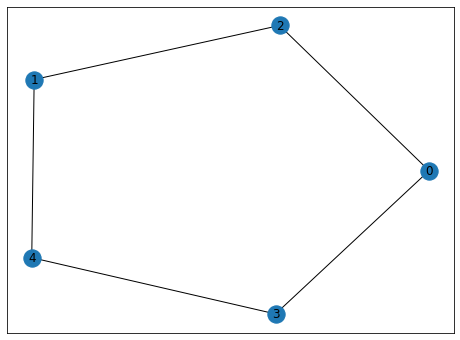

In [4]:
# visualize the graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(maxcut_graph, ax=ax)

In [5]:
cirq_qubits = cirq.GridQubit.rect(1, 5)

In [6]:
# create layer of hadamards to initialize the superposition state of all 
# computational states
hadamard_circuit = cirq.Circuit()
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    hadamard_circuit.append(cirq.H.on(qubit))

In [7]:
# define the two parameters for one block of QAOA
qaoa_parameters = sympy.symbols('a b')

In [8]:
# define the the mixing and the cost Hamiltonian, H_M and H_P
mixing_ham = 0
for node in maxcut_graph.nodes():
    qubit = cirq_qubits[node]
    mixing_ham += cirq.PauliString(cirq.X(qubit))

cost_ham = maxcut_graph.number_of_edges()/2
for edge in maxcut_graph.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))

# generate the qaoa circuit
qaoa_circuit = tfq.util.exponential(operators = [cost_ham, mixing_ham], 
                                    coefficients = qaoa_parameters)

In [9]:
# define the model and training data
model_circuit, model_readout = qaoa_circuit, cost_ham
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)
optimum = [0]

In [10]:
# Build the Keras model.
optimum=np.array(optimum)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
model.add(tfq.layers.PQC(model_circuit, model_readout))
tfq.layers.PQC

tensorflow_quantum.python.layers.high_level.pqc.PQC

In [ ]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adam())
          
history = model.fit(input_,optimum,epochs=1000,verbose=1)

Train on 1 samples
Epoch 1/1000
1/1 [==============================] - 1s 1s/sample - loss: 3.5336
Epoch 2/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.5315
Epoch 3/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5295
Epoch 4/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.5274
Epoch 5/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5253
Epoch 6/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.5232
Epoch 7/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5211
Epoch 8/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5190
Epoch 9/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5168
Epoch 10/1000
1/1 [==============================] - 0s 2ms/sample - loss: 3.5146
Epoch 11/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5124
Epoch 12/1000
1/1 [==============================] - 0s 3ms/sample - loss: 3.5102
Epoch 1

In [ ]:
plt.plot(history.history['loss'])
plt.title("QAOA with TFQ")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [11]:
# Read out the optimal paramters and sample from the final state 1000 times
params = model.trainable_variables
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append =qaoa_circuit )

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params,repetitions=1000)

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [12]:
# Translate output in cut sets
cuts_qaoa = []
for bit_string in output.values:
  temp = []
  for pos, bit in enumerate(bit_string):
    if bit==1:
      temp.append(pos)
  cuts_qaoa.append(temp)

In [13]:
# Generate a list with all possible subsets
from itertools import combinations
sub_lists = []
for i in range(0, len(maxcut_graph.nodes())+1):
  temp = [list(x) for x in combinations(maxcut_graph.nodes(), i)]
  sub_lists.extend(temp)

In [14]:
# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(maxcut_graph,sub_list))

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(maxcut_graph,cut))

In [15]:
# Calculate the approximation ratio
np.mean(cut_size_qaoa)/np.max(cut_size)

0.5185